In [1]:
import sympy as sp
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from CommonFunctions import *
%matplotlib inline

# Harmonic oscillators

## Linear harmonic oscillator

$$ \alpha \frac{d^2x}{dt^2} + \beta \frac{dx}{dt} + \omega x = F \cos{\Omega t} $$

With initial conditions:

$$x(0) = 1, x'(0) = 0$$

In [2]:
t, beta, omega, F, Omega = sp.symbols('t beta omega F Omega')
x = sp.Function('x')
diff_eq = sp.Eq(x(t).diff(t, 2) + beta*x(t).diff(t) + omega * x(t), F * sp.cos(Omega * t))
diff_eq

Eq(beta*Derivative(x(t), t) + omega*x(t) + Derivative(x(t), (t, 2)), F*cos(Omega*t))

In [3]:
beta_val, omega_val, F_val, Omega_val = sp.Rational(1, 4), 1, 2, 2
beta_val_float = 1/4
x_eq = diff_eq.subs([(beta, beta_val), (omega, omega_val), (F, F_val), (Omega, Omega_val)])
x_eq

Eq(x(t) + Derivative(x(t), t)/4 + Derivative(x(t), (t, 2)), 2*cos(2*t))

In [4]:
ics = {x(0): 5, x(t).diff(t).subs(t, 0): 0}
oscillator_sol = sp.dsolve(x_eq, x(t), ics=ics)
oscillator_sol

Eq(x(t), (145*sqrt(7)*sin(3*sqrt(7)*t/8)/777 + 209*cos(3*sqrt(7)*t/8)/37)*exp(-t/8) + 4*sin(2*t)/37 - 24*cos(2*t)/37)

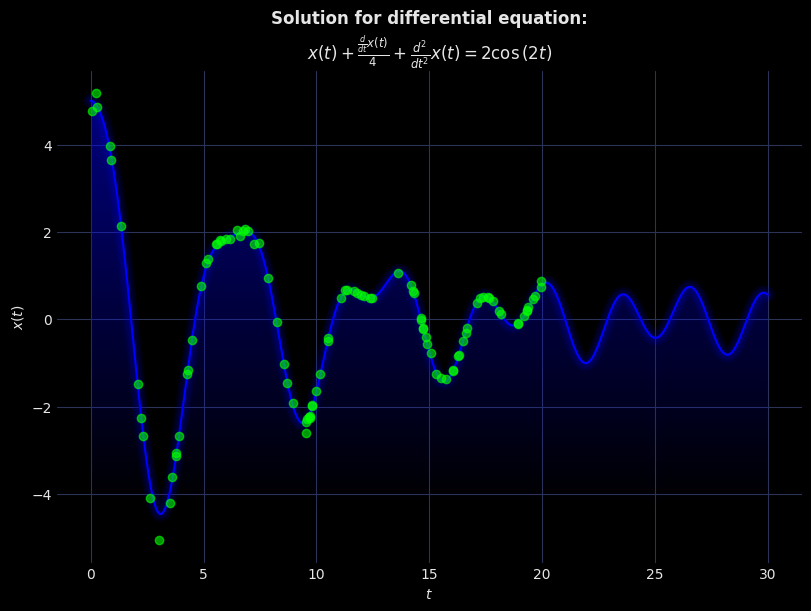

In [5]:
t_max = 30
t_values = np.linspace(0, t_max, 1001)
oscillator_function = sp.lambdify(t, oscillator_sol.rhs, 'numpy')

datapoints = {'t': np.random.uniform(0, 20, 100)}
datapoints['x'] = (x_true := oscillator_function(datapoints['t'])) + np.random.normal(0, np.abs(x_true) * 0.05)

with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.plot(t_values, oscillator_function(t_values), color='blue')
    axes.scatter(datapoints['t'], datapoints['x'], color='lime', zorder=10, alpha=0.6)
    # axes.grid()
    axes.set(xlabel='$t$', ylabel='$x(t)$',
             title=f'Solution for differential equation:\n'
                   f'${sp.latex(x_eq)}$')
    enhance_plot(figure, axes, glow=True, alpha_gradient=0.5)

# Creating the models

In [6]:
class ModularNeuralNetwork(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 output_size: int, 
                 layer_sizes: tuple[int] = (), 
                 activation_function: nn.modules.activation = nn.Tanh()):
        super(ModularNeuralNetwork, self).__init__()
        if len(layer_sizes) == 0:
            self.layers = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=output_size),
                activation_function
            )
        elif len(layer_sizes) == 1:
            size = layer_sizes[0]
            self.layers = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=size),
                activation_function,
                nn.Linear(in_features=size, out_features=output_size),
                activation_function
            )
        else:
            layers = []
            for index, layer_size in enumerate(layer_sizes):
                if index == 0:
                    layer = nn.Linear(in_features=input_size, out_features=layer_size)
                else:
                    layer = nn.Linear(in_features=layer_sizes[index - 1], 
                                      out_features=layer_size)
                layers += [layer, activation_function]
            layers += [nn.Linear(in_features=layer_sizes[-1], 
                                 out_features=output_size)]
            self.layers = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = torch.tensor(datapoints['t'], dtype=torch.float32).unsqueeze(dim=1).to(device)
y = torch.tensor(datapoints['x'], dtype=torch.float32).unsqueeze(dim=1).to(device)
epochs = 15000
learning_rate = 0.005
hidden_layers = 200, 200, 200
NN = ModularNeuralNetwork(input_size=1,
                          output_size=1,
                          layer_sizes=hidden_layers,
                          activation_function=nn.Tanh()).to(device)
optimizer = torch.optim.Adam(NN.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
loss_array_nn = np.zeros(epochs)
NN.train()
for epoch in range(epochs):
    y_pred = NN(X)
    loss = criterion(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_array_nn[epoch] = loss.item()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 3.4404149055480957
Epoch 1000, Loss: 0.019353248178958893
Epoch 2000, Loss: 0.015197532251477242
Epoch 3000, Loss: 0.015569578856229782
Epoch 4000, Loss: 0.007932241074740887
Epoch 5000, Loss: 0.002752850065007806
Epoch 6000, Loss: 0.0035114805214107037
Epoch 7000, Loss: 0.0025805889163166285
Epoch 8000, Loss: 0.0029194732196629047
Epoch 9000, Loss: 0.0027696751058101654
Epoch 10000, Loss: 0.003761248430237174
Epoch 11000, Loss: 0.003915291745215654
Epoch 12000, Loss: 0.0010391660034656525
Epoch 13000, Loss: 0.002664098283275962
Epoch 14000, Loss: 0.0014906906289979815


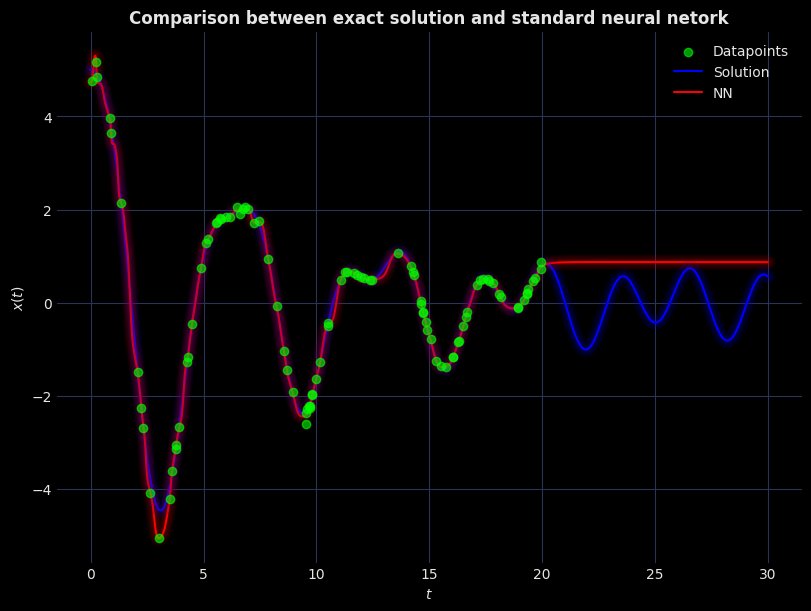

In [8]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.scatter(datapoints['t'], datapoints['x'], color='lime', label='Datapoints', zorder=10, alpha=0.6)
    axes.plot(t_values, oscillator_function(t_values), color='blue', label='Solution')
    t_val_tensor = torch.tensor(t_values, dtype=torch.float32).unsqueeze(dim=1)
    axes.plot(t_val_tensor, NN(t_val_tensor.cuda()).cpu().detach(), color='red', label='NN')
    axes.legend()
    axes.set(xlabel='$t$', ylabel='$x(t)$',
             title='Comparison between exact solution and standard neural netork')
    enhance_plot(figure, axes, glow=True)

In [9]:
X = torch.tensor(datapoints['t'], dtype=torch.float32).unsqueeze(dim=1).to(device)
y = torch.tensor(datapoints['x'], dtype=torch.float32).unsqueeze(dim=1).to(device)
X_physics = torch.from_numpy(t_values).to(torch.float32).unsqueeze(dim=1).requires_grad_(True).to(device)
epochs = 25000
learning_rate = 0.0005
hidden_layers = 200, 200, 200
physics_lambda = 10
PINN = ModularNeuralNetwork(input_size=1,
                            output_size=1,
                            layer_sizes=hidden_layers,
                            activation_function=nn.Tanh()).to(device)
optimizer = torch.optim.Adam(PINN.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
loss_array_pinn = np.zeros(epochs)
PINN.train()
for epoch in range(epochs):
    y_pred = PINN(X)
    loss1 = criterion(y_pred, y)
    y_physics = PINN(X_physics)
    dx = torch.autograd.grad(
        y_physics, X_physics,
        grad_outputs=torch.ones_like(y_physics),
        create_graph=True)[0]
    dx2 = torch.autograd.grad(
        dx, X_physics,
        grad_outputs=torch.ones_like(dx),
        create_graph=True)[0]
    pde = ((omega_val) * y_physics) + (dx * beta_val_float) + dx2 - (F_val * torch.cos(Omega_val * X_physics))
    loss2 = physics_lambda * torch.mean(pde ** 2)
    loss = loss1 + loss2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_array_pinn[epoch] = loss.item()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, MSE Loss: {loss1.item()}, Physics Loss: {loss2.item()}')

Epoch 0, MSE Loss: 3.577191114425659, Physics Loss: 20.620258331298828
Epoch 1000, MSE Loss: 0.9997093081474304, Physics Loss: 15.963647842407227
Epoch 2000, MSE Loss: 0.19778282940387726, Physics Loss: 12.143669128417969
Epoch 3000, MSE Loss: 0.24187953770160675, Physics Loss: 11.318094253540039
Epoch 4000, MSE Loss: 0.03569110482931137, Physics Loss: 8.034858703613281
Epoch 5000, MSE Loss: 0.08853410184383392, Physics Loss: 6.8820672035217285
Epoch 6000, MSE Loss: 0.022652268409729004, Physics Loss: 5.102525234222412
Epoch 7000, MSE Loss: 0.014280300587415695, Physics Loss: 3.51621675491333
Epoch 8000, MSE Loss: 0.013421480543911457, Physics Loss: 1.757561206817627
Epoch 9000, MSE Loss: 0.0194175373762846, Physics Loss: 1.1834897994995117
Epoch 10000, MSE Loss: 0.012492401525378227, Physics Loss: 0.6060014963150024
Epoch 11000, MSE Loss: 0.008802681230008602, Physics Loss: 0.0334366112947464
Epoch 12000, MSE Loss: 0.008550134487450123, Physics Loss: 0.0019738187547773123
Epoch 13000,

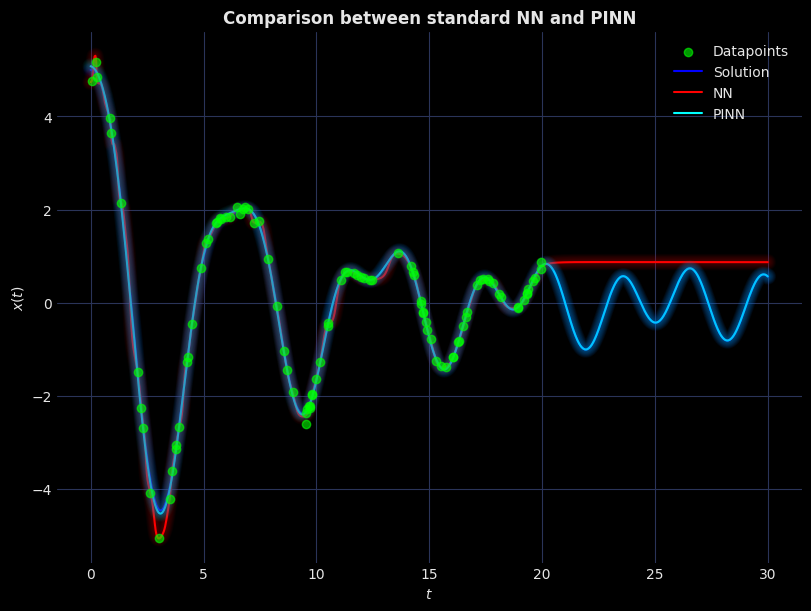

In [10]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.scatter(datapoints['t'], datapoints['x'], color='lime', label='Datapoints', zorder=10, alpha=0.6)
    axes.plot(t_values, oscillator_function(t_values), color='blue', label='Solution')
    t_val_tensor = torch.tensor(t_values, dtype=torch.float32).unsqueeze(dim=1)
    axes.plot(t_val_tensor, NN(t_val_tensor.cuda()).cpu().detach(), color='red', label='NN')
    axes.plot(t_val_tensor, PINN(t_val_tensor.cuda()).cpu().detach(), color='cyan', label='PINN')
    axes.legend()
    axes.set(xlabel='$t$', ylabel='$x(t)$',
             title=f'Comparison between standard NN and PINN')
    enhance_plot(figure, axes, glow=True)

# Approximating the damping factor $\beta$

In [11]:
class BetaApproximator(ModularNeuralNetwork):
    def __init__(self,
                 input_size: int,
                 output_size: int,
                 layer_sizes:tuple[int] = (),
                 activation_function: nn.Module = nn.Tanh()):
        super(BetaApproximator, self).__init__(
            input_size, output_size,
            layer_sizes=layer_sizes,
            activation_function=activation_function
        )
        self.beta = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True)

In [12]:
X = torch.tensor(datapoints['t'], dtype=torch.float32).unsqueeze(dim=1).to(device)
y = torch.tensor(datapoints['x'], dtype=torch.float32).unsqueeze(dim=1).to(device)
X_physics = torch.from_numpy(t_values).to(torch.float32).unsqueeze(dim=1).requires_grad_(True).to(device)
epochs = 75000
learning_rate = 0.0005
hidden_layers = 200, 200, 200
physics_lambda = 10
Approximator = BetaApproximator(
    input_size=1,
    output_size=1,
    layer_sizes=hidden_layers,
    activation_function=nn.Tanh()).to(device)
optimizer = torch.optim.Adam(Approximator.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
loss_array_app = np.zeros(epochs)
Approximator.train()
for epoch in range(epochs):
    y_pred = Approximator(X)
    loss1 = criterion(y_pred, y)
    y_physics = Approximator(X_physics)
    dx = torch.autograd.grad(
        y_physics, X_physics,
        grad_outputs=torch.ones_like(y_physics),
        create_graph=True)[0]
    dx2 = torch.autograd.grad(
        dx, X_physics,
        grad_outputs=torch.ones_like(dx),
        create_graph=True)[0]
    pde = (y_physics * omega_val) + (dx * Approximator.beta) + dx2 - (F_val * torch.cos(Omega_val * X_physics))
    loss2 = physics_lambda * torch.mean(pde ** 2)
    loss = loss1 + loss2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_array_app[epoch] = loss.item()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, MSE Loss: {loss1.item()}, Physics Loss: {loss2.item()}')

Epoch 0, MSE Loss: 3.466721773147583, Physics Loss: 20.089704513549805
Epoch 1000, MSE Loss: 1.0373730659484863, Physics Loss: 15.869623184204102
Epoch 2000, MSE Loss: 0.5947965979576111, Physics Loss: 13.629141807556152
Epoch 3000, MSE Loss: 0.25982245802879333, Physics Loss: 11.131765365600586
Epoch 4000, MSE Loss: 0.08377929776906967, Physics Loss: 7.213469505310059
Epoch 5000, MSE Loss: 0.029857212677598, Physics Loss: 4.1039652824401855
Epoch 6000, MSE Loss: 0.03148186579346657, Physics Loss: 3.042720317840576
Epoch 7000, MSE Loss: 0.028865937143564224, Physics Loss: 1.5223652124404907
Epoch 8000, MSE Loss: 0.04924880713224411, Physics Loss: 0.6914921998977661
Epoch 9000, MSE Loss: 0.013923438265919685, Physics Loss: 0.1147809624671936
Epoch 10000, MSE Loss: 0.008565429598093033, Physics Loss: 0.002930008340626955
Epoch 11000, MSE Loss: 0.008547896519303322, Physics Loss: 0.0009251536685042083
Epoch 12000, MSE Loss: 0.018480580300092697, Physics Loss: 0.22145970165729523
Epoch 130

In [13]:
print(f'Comparison between real and approximated values:\n'
      f'beta: real = {beta_val:.3f}, approximated: {Approximator.beta.item():.3f}\n')

Comparison between real and approximated values:
beta: real = 0.250, approximated: 0.250


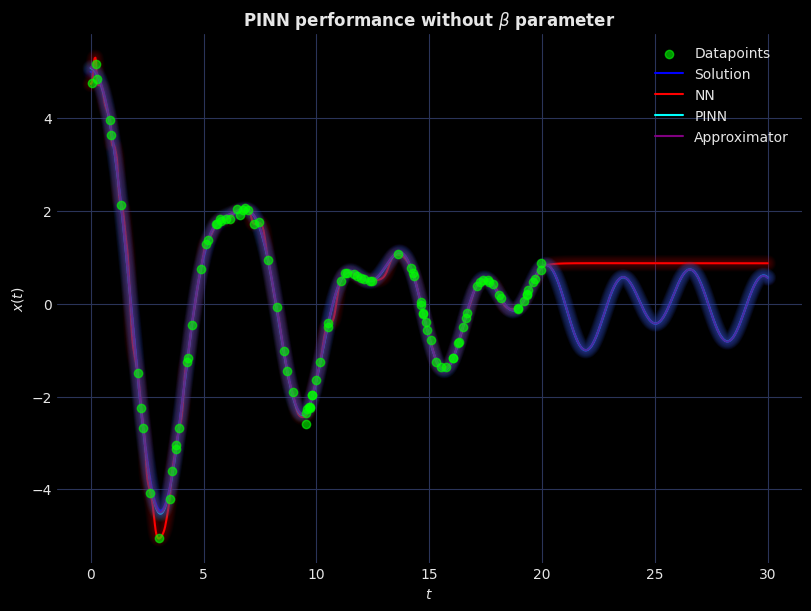

In [14]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.scatter(datapoints['t'], datapoints['x'], color='lime', label='Datapoints', zorder=10, alpha=0.6)
    axes.plot(t_values, oscillator_function(t_values), color='blue', label='Solution')
    t_val_tensor = torch.tensor(t_values, dtype=torch.float32).unsqueeze(dim=1)
    axes.plot(t_val_tensor, NN(t_val_tensor.cuda()).cpu().detach(), color='red', label='NN')
    axes.plot(t_val_tensor, PINN(t_val_tensor.cuda()).cpu().detach(), color='cyan', label='PINN')
    axes.plot(t_val_tensor, Approximator(t_val_tensor.cuda()).cpu().detach(), color='purple', label='Approximator')
    axes.legend()
    axes.set(xlabel='$t$', ylabel='$x(t)$',
             title=f'PINN performance without $\\beta$ parameter')
    enhance_plot(figure, axes, glow=True)

We can see that approximator struggles for region outside of the sampled data, but it still performs way better than normal neural network. Let's add more samples from wider range. Let's add more noise.

# Approximating all parameters:
* damping factor $\beta$
* oscillator frequency $\omega$
* driving force frequency $\Omega$

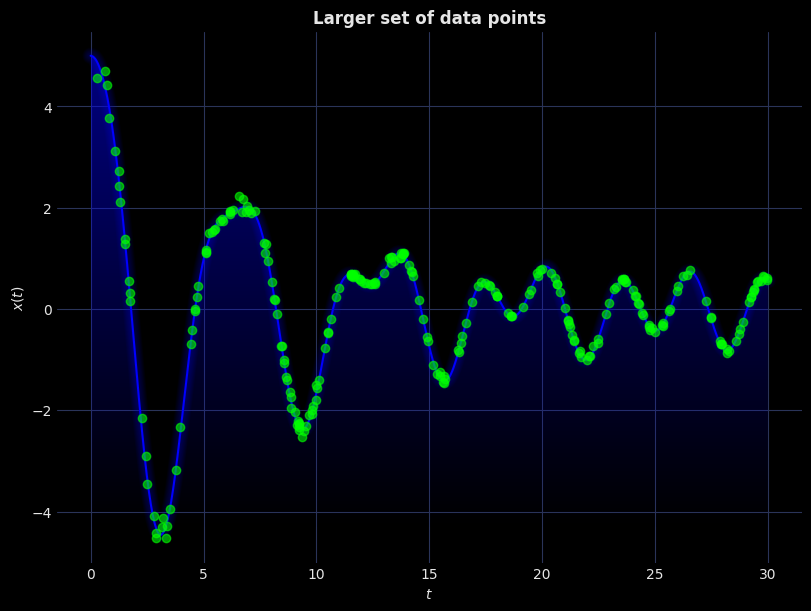

In [15]:
oscillator_function = sp.lambdify(t, oscillator_sol.rhs, 'numpy')

datapoints = {'t': np.random.uniform(0, t_max, 250)}
datapoints['x'] = (x_true := oscillator_function(datapoints['t'])) + np.random.normal(0, np.abs(x_true) * 0.05)

with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.scatter(datapoints['t'], datapoints['x'], color='lime', zorder=10, alpha=0.6, label='Datapoints')
    axes.plot(t_values, oscillator_function(t_values), color='blue', label='Solution')
    # axes.grid()
    axes.set(xlabel='$t$', ylabel='$x(t)$', title='Larger set of data points')
    enhance_plot(figure, axes, glow=True, alpha_gradient=0.5)

In [33]:
class OscillatorApproximator(ModularNeuralNetwork):
    def __init__(self,
                 input_size: int,
                 output_size: int,
                 layer_sizes:tuple[int] = (),
                 activation_function: nn.Module = nn.Tanh()):
        super(OscillatorApproximator, self).__init__(
            input_size, output_size,
            layer_sizes=layer_sizes,
            activation_function=activation_function
        )
        
        initial_value = 2
        self.beta = nn.Parameter(torch.tensor([initial_value], dtype=torch.float32), requires_grad=True)
        self.omega = nn.Parameter(torch.tensor([initial_value], dtype=torch.float32), requires_grad=True)
        self.F = nn.Parameter(torch.tensor([initial_value], dtype=torch.float32), requires_grad=True)
        self.Omega = nn.Parameter(torch.tensor([initial_value], dtype=torch.float32), requires_grad=True)

In [37]:
X = torch.tensor(datapoints['t'], dtype=torch.float32).unsqueeze(dim=1).to(device)
y = torch.tensor(datapoints['x'], dtype=torch.float32).unsqueeze(dim=1).to(device)
X_physics = torch.from_numpy(t_values).to(torch.float32).unsqueeze(dim=1).requires_grad_(True).to(device)
epochs = 150000
learning_rate = 0.0001
hidden_layers = 1000, 1000
physics_lambda = 10
mse_lambda = 1
Approximator2 = OscillatorApproximator(
    input_size=1,
    output_size=1,
    layer_sizes=hidden_layers,
    activation_function=nn.Tanh()).to(device)
optimizer = torch.optim.Adam(Approximator2.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
loss_array_app = np.zeros(epochs)
Approximator2.train()
for epoch in range(epochs):
    y_pred = Approximator2(X)
    loss1 = mse_lambda * criterion(y_pred, y)
    y_physics = Approximator2(X_physics)
    dx = torch.autograd.grad(
        y_physics, X_physics,
        grad_outputs=torch.ones_like(y_physics),
        create_graph=True)[0]
    dx2 = torch.autograd.grad(
        dx, X_physics,
        grad_outputs=torch.ones_like(dx),
        create_graph=True)[0]
    pde = (y_physics * Approximator2.omega) + (dx * Approximator2.beta) + dx2 - (Approximator2.F * torch.cos(Approximator2.Omega * X_physics))
    loss2 = physics_lambda * torch.mean(pde ** 2)
    loss = loss1 + loss2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_array_app[epoch] = loss.item()
    if epoch % 2000 == 0:
        print(f'Epoch {epoch}, MSE Loss: {loss1.item()}, Physics Loss: {loss2.item()}')

Epoch 0, MSE Loss: 2.123636245727539, Physics Loss: 20.337316513061523
Epoch 2000, MSE Loss: 1.5842002630233765, Physics Loss: 13.667219161987305
Epoch 4000, MSE Loss: 1.5668461322784424, Physics Loss: 10.547738075256348
Epoch 6000, MSE Loss: 1.5312434434890747, Physics Loss: 8.037346839904785
Epoch 8000, MSE Loss: 1.4655237197875977, Physics Loss: 6.0306396484375
Epoch 10000, MSE Loss: 1.3426018953323364, Physics Loss: 4.218016624450684
Epoch 12000, MSE Loss: 1.1442826986312866, Physics Loss: 2.563493490219116
Epoch 14000, MSE Loss: 0.918956458568573, Physics Loss: 1.5707701444625854
Epoch 16000, MSE Loss: 0.6252572536468506, Physics Loss: 0.8699430227279663
Epoch 18000, MSE Loss: 0.4167262017726898, Physics Loss: 0.4390018582344055
Epoch 20000, MSE Loss: 0.2734909653663635, Physics Loss: 0.17713728547096252
Epoch 22000, MSE Loss: 0.2274751514196396, Physics Loss: 0.059134457260370255
Epoch 24000, MSE Loss: 0.22317498922348022, Physics Loss: 0.02661161869764328
Epoch 26000, MSE Loss: 

In [38]:
print(f'Comparison between real and approximated values:\n'
      f'beta: real = {beta_val:.3f}, approximated: {Approximator2.beta.item():.3f}\n'
      f'omega: real = {omega_val:.3f}, approximated: {Approximator2.omega.item():.3f}\n'
      f'F: real = {F_val:.3f}, approximated: {Approximator2.F.item():.3f}\n'
      f'Omega: real = {Omega_val:.3f}, approximated: {Approximator2.Omega.item():.3f}')

Comparison between real and approximated values:
beta: real = 0.250, approximated: 0.248
omega: real = 1.000, approximated: 1.002
F: real = 2.000, approximated: 1.981
Omega: real = 2.000, approximated: 2.000


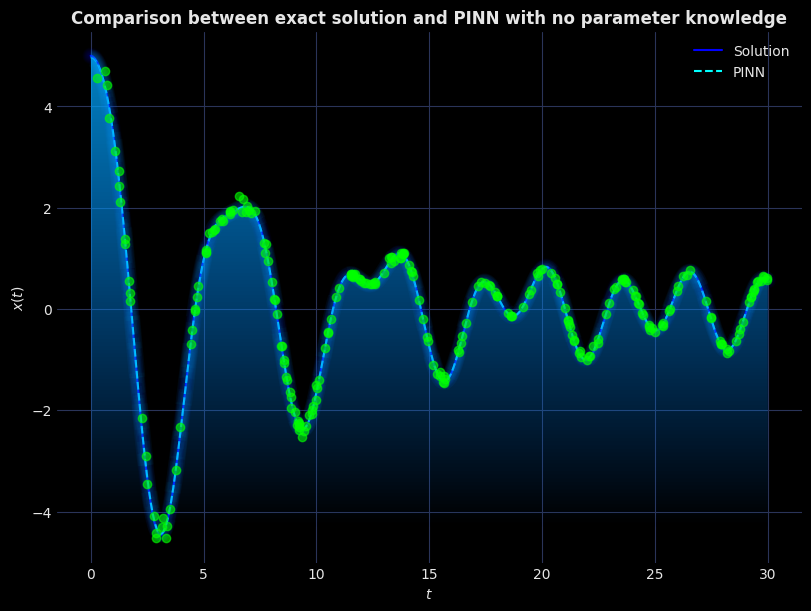

In [39]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.scatter(datapoints['t'], datapoints['x'], color='lime', zorder=10, alpha=0.6)
    axes.plot(t_values, oscillator_function(t_values), color='blue', label='Solution')
    axes.plot(t_val_tensor, Approximator2(t_val_tensor.cuda()).cpu().detach(), color='cyan', linestyle='--',
              label='PINN')
    # axes.grid()
    axes.legend()
    axes.set(xlabel='$t$', ylabel='$x(t)$',
             title=f'Comparison between exact solution and PINN with no parameter knowledge')
    enhance_plot(figure, axes, glow=True, alpha_gradient=0.5)